
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1
Number of training examples: 60000
Number of test examples:     10000


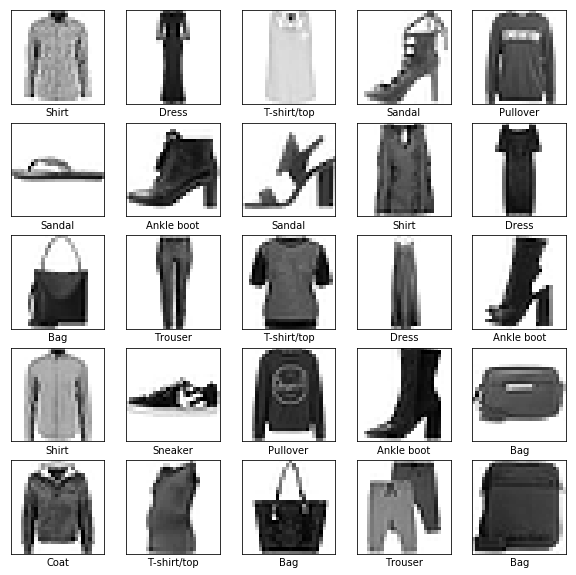

Epoch 1/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.4937 - acc: 0.8276
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3722 - acc: 0.8653
Epoch 3/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3385 - acc: 0.8758
Epoch 4/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3081 - acc: 0.8874
Epoch 5/5
313/313 [==============================] - 2s 8ms/step - loss: 0.3514 - acc: 0.8742
Accuracy on test dataset: 0.8742
Getting predictions of the first batch of test sets...
Shape of predictions: (32, 10)


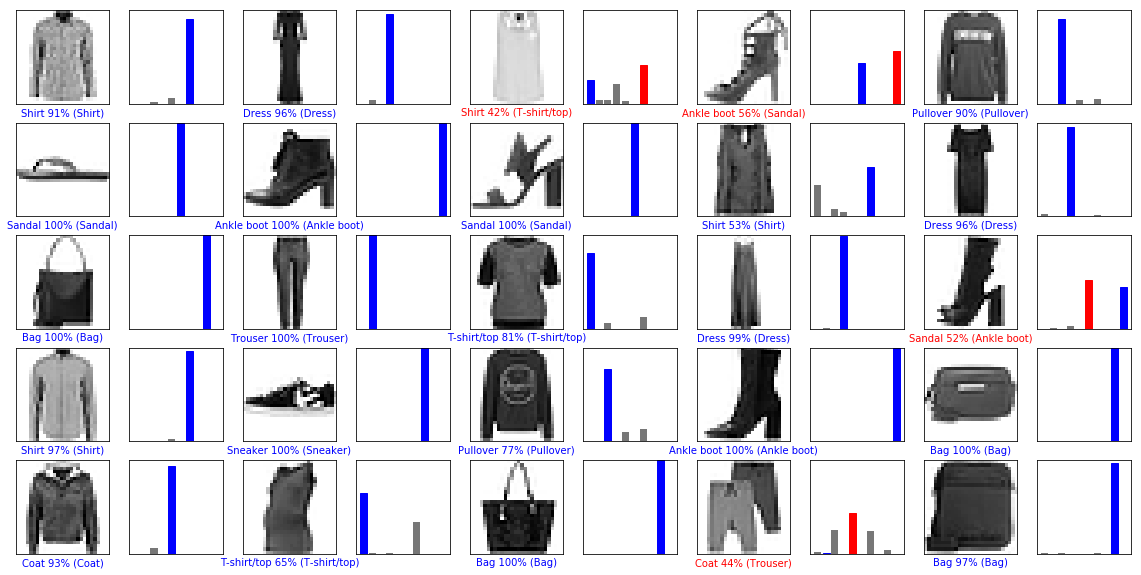

In [1]:
%matplotlib inline

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)

# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()  

# We will use 60,000 images to train the network and 10,000 images to evaluate 
# how accurately the network learned to classify images. You can access the Fashion MNIST 
# directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Each image is mapped to a single label. Since the *class names* are not included with the dataset, 
# store them here to use later when plotting the images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# Let's explore the format of the dataset before training the model. 
# The following shows there are 60,000 images in the training set, and 10000 images in the test set
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

# The value of each pixel in the image data is an integer in the range `[0,255]`. 
# For the model to work properly, these values need to be normalized to the range `[0,1]`. 
# So here we create a normalization function, and then apply it to each image in the test and train datasets.
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Display the first 25 images from the *training set* and display the class name below each image. 
# Verify that the data is in the correct format and we're ready to build and train the network.
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# The basic building block of a neural network is the layer. 
# A layer extracts a representation from the data fed into it. 
# Hopefully, a series of connected layers results in a representation that is meaningful for the 
# problem at hand.
# Much of deep learning consists of chaining together simple layers. 
# Most layers, like tf.keras.layers.Dense, have internal parameters which are adjusted ("learned") 
# during training.
model = tf.keras.Sequential([
    # input tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28  ×  28 pixels), 
    # to a 1d-array of 784 pixels (28*28). Think of this layer as unstacking rows of pixels in the image and 
    # lining them up. This layer has no parameters to learn, as it only reformats the data.
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    # "hidden" tf.keras.layers.Dense — A densely connected layer of 128 neurons. Each neuron (or node) 
    # takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters 
    # which will be learned during training, and outputs a single value to the next layer.
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    # output tf.keras.layers.Dense — A 10-node softmax layer, with each node representing a class of clothing. 
    # As in the previous layer, each node takes input from the 128 nodes in the layer before it. 
    # Each node weights the input according to learned parameters, and then outputs a value in the range [0, 1], 
    # representing the probability that the image belongs to that class. The sum of all 10 node values is 1.
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

# Before the model is ready for training, it needs a few more settings. These are added during the model's 
#   compile step:
# Loss function — An algorithm for measuring how far the model's outputs are from the desired output. 
#   The goal of training is this measures loss.
# Optimizer — An algorithm for adjusting the inner parameters of the model in order to minimize loss.
# Metrics — Used to monitor the training and testing steps. 
#   The following example uses accuracy, the fraction of the images that are correctly classified.
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# First, we define the iteration behavior for the train dataset:
# Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we 
# perform training).
# The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the 
# examples.
# And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model 
# variables.
# Training is performed by calling the model.fit method:
# Feed the training data to the model using train_dataset.
# The model learns to associate images and labels.
# The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 
# 5 * 60000 = 300000 examples.
# (Don't worry about steps_per_epoch, the requirement to have this flag will soon be removed.)
# As the model trains, the loss and accuracy metrics are displayed. This model reaches an 
# accuracy of about 0.88 (or 88%) on the training data.
    
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

# Next, compare how the model performs on the test dataset. 
# Use all examples we have in the test dataset to assess accuracy.
# As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. 
# This is completely normal, since the model was trained on the train_dataset. 
# When the model sees images it has never seen during training,(that is, from the test_dataset), 
# we can expect performance to go down.
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

# Get predictions of the first batch of test sets
print('Getting predictions of the first batch of test sets...')
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
print('Shape of predictions: {}'.format(predictions.shape))

# We can graph this to look at the full set of 10 channels
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
    

# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [2]:
## Make predictions and explore
# With the model trained, we can use it to make predictions about some images.
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape

# Here, the model has predicted the label for each image in the testing set. 
# Let's take a look at the first prediction:
print("predicted probabilities: {}".format(predictions[0]))

# A prediction is an array of 10 numbers. 
# These describe the "confidence" of the model that the image corresponds to each of the 
# 10 different articles of clothing. We can see which label has the highest confidence value:
print("prediction: {}".format(class_names[np.argmax(predictions[0])]))

# So the model is most confident that this image is a shirt, or `class_names[6]`.
# And we can check the test label to see this is correct:
print("correct value: {}".format(class_names[test_labels[0]]))

predicted probabilities: [2.3233888e-05 5.0228067e-08 2.2968031e-02 3.8196475e-05 6.8321712e-02
 7.0586430e-07 9.0864217e-01 3.9786229e-08 5.9643958e-06 5.1113109e-09]
prediction: Shirt
correct value: Shirt


Image shape: 
Image shape, added to an array: 
predicted probabilities: [[1.23468453e-07 2.92133162e-09 9.23000272e-08 3.50157535e-07
  7.88876207e-07 8.23891469e-07 1.41620395e-08 5.62769446e-06
  9.99992132e-01 2.70382740e-12]]
prediction: Bag


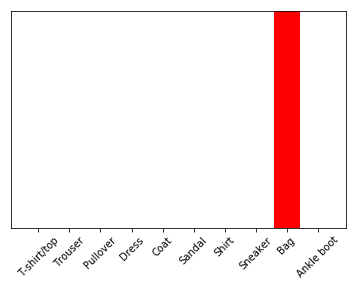

In [3]:
# Grab an image from the test dataset
img = test_images[10] # modify the index to get the requested image

print("Image shape: ".format(img.shape))

# tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. 
# So even though we're using a single image, we need to add it to a list:
# Add the image to a batch where it's the only member.
img = np.array([img])

print("Image shape, added to an array: ".format(img.shape))

# Now predict the image:
predictions_single = model.predict(img)

print("predicted probabilities: {}".format(predictions_single))

# plot the prediction
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

print("prediction: {}".format(class_names[np.argmax(predictions_single[0])]))